In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

font = {'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
SEED = 947
torch_utils.seed_everything(947)

In [3]:
import spacy
spacy_de = spacy.load("de")
spacy_en = spacy.load("en")

In [4]:
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

In [5]:
from torchtext import data, datasets

In [6]:
SRC = data.Field(
    tokenize=tokenize_de,
    init_token="<sos>",
    eos_token="<eos>",
    lower=True
)
TRG = data.Field(
    tokenize=tokenize_en,
    init_token="<sos>",
    eos_token="<eos>",
    lower=True
)

In [7]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=(".de",".en"), fields=(SRC, TRG))

In [8]:
len(train_data),len(valid_data), len(test_data)

(29000, 1014, 1000)

In [9]:
vars(train_data.examples[0])

{'src': ['.',
  'büsche',
  'vieler',
  'nähe',
  'der',
  'in',
  'freien',
  'im',
  'sind',
  'männer',
  'weiße',
  'junge',
  'zwei'],
 'trg': ['two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.']}

In [10]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [11]:
print(len(SRC.vocab)," words in Source")
print(len(TRG.vocab)," words in Target")

7855  words in Source
5893  words in Target


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data,valid_data, test_data),
    batch_sizes=(BATCH_SIZE,BATCH_SIZE,BATCH_SIZE),
    device=device
)

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        # srclen x batch_size (standard lstm input shape)
        embedded = self.dropout(self.embedding(src))
        #srclen X batch_size X emb_dim
        ot,(ht,ct) = self.rnn(embedded)
        # ot = src_len X batch_size X hidden_dim*n_directions
        # ht = n_layers*n_directions X batch_size X hid_dim
        # ct = n_layers*n_directions X batch_size X hid_dim
        
        return ht, ct

In [15]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, ht, ct):
        # trg = batch_size
        # ht = n_directions*n_layers X batch_size X hid_dim
        # ct = n_directions*n_layers X batch_size X hid_dim
        
        # add a fake seq_len dimension
        trg = trg.unsqueeze(0)
        embedded = self.dropout(self.embedding(trg))
        
        # embedded = 1 X batch_size X emb_dim
        
        ot, (ht, ct) = self.rnn(embedded, (ht, ct))
        
        preds = self.fc_out(ot.squeeze(0))
        
        return preds, (ht, ct)

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, "ENC_HID_DIM MUST == DEC_HID_DIM"
        assert encoder.n_layers == decoder.n_layers, "ENC_LAYERS MUST == DEC_LAYERS"
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        ht,ct = self.encoder(src)
        
        current_token = trg[0, :]
        
        for t in range(1, trg_len):
            ot, (ht, ct) = self.decoder(current_token, ht, ct)
            outputs[t] = ot
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = ot.argmax(1)
            
            current_token = trg[t] if teacher_force else top1

        return outputs

In [17]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    l = 0
    
    for i, batch in enumerate(tqdm(iterator)):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output = model(src, trg)
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        l+=loss.item()
    
    return l/len(iterator)

In [30]:
def evaluate(model, iterator, criterion):
    model.eval()
    l = 0
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator)):
            src = batch.src
            trg = batch.trg
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            l+=loss.item()
    
    return l/len(iterator)

In [31]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [32]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROP = 0.5
DEC_DROP = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROP)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROP)


torch_utils.clear_cuda()

model = Seq2Seq(enc, dec, device).to(device)
model = model.apply(init_weights)

In [33]:
torch_utils.count_model_params(model)

13899013

In [34]:
optimizer = torch_utils.RAdam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
N_EPOCHS = 20
CLIP = 1
history = pd.DataFrame()
ea = torch_utils.EarlyStopping(patience=7, verbose=True)

In [39]:
for epoch in range(N_EPOCHS):
    st = time.time()
    torch_utils.clear_cuda()
    tl = train(model, train_iterator, optimizer, criterion, CLIP)
    vl = evaluate(model, valid_iterator, criterion)
    torch_utils.print_epoch_stat(epoch, time.time()-st, history=history, train_loss=tl, valid_loss=vl)
    history.loc[epoch, "TPL"] = math.exp(tl)
    history.loc[epoch, "VPL"] = math.exp(vl)
    ea(history.loc[epoch, "VPL"], model)
    
    print("\tTPL: \t{:0.5}".format(history.loc[epoch, "TPL"]))
    print("\tVPL: \t{:0.5}".format(history.loc[epoch, "VPL"]))
    
    if ea.early_stop:
        print("STOPPING EARLY")
        break




EPOCH 1 Completed, Time Taken: 0:00:27.188844
	Train Loss 	2.50585641
	Valid Loss 	2.98432052
EarlyStopping counter: 1 out of 7
	TPL: 	12.254
	VPL: 	19.773





EPOCH 2 Completed, Time Taken: 0:00:27.394156
	Train Loss 	2.45103921
	Valid Loss 	2.84632772
Found better solution (17.481294 --> 17.224413).  Saving model ...
	TPL: 	11.6
	VPL: 	17.224





EPOCH 3 Completed, Time Taken: 0:00:27.403106
	Train Loss 	2.37129268
	Valid Loss 	2.94337261
EarlyStopping counter: 1 out of 7
	TPL: 	10.711
	VPL: 	18.98





EPOCH 4 Completed, Time Taken: 0:00:27.306852
	Train Loss 	2.32345327
	Valid Loss 	2.85077816
EarlyStopping counter: 2 out of 7
	TPL: 	10.211
	VPL: 	17.301





EPOCH 5 Completed, Time Taken: 0:00:27.277154
	Train Loss 	2.25458956
	Valid Loss 	2.81534567
Found better solution (17.224413 --> 16.698947).  Saving model ...
	TPL: 	9.5314
	VPL: 	16.699





EPOCH 6 Completed, Time Taken: 0:00:27.499796
	Train Loss 	2.18047531
	Valid Loss 	2.81876755
EarlyStopping counter: 1 out of 7
	TPL: 	8.8505
	VPL: 	16.756





EPOCH 7 Completed, Time Taken: 0:00:27.512395
	Train Loss 	2.11719082
	Valid Loss 	2.89752665
EarlyStopping counter: 2 out of 7
	TPL: 	8.3078
	VPL: 	18.129





EPOCH 8 Completed, Time Taken: 0:00:26.628326
	Train Loss 	2.04994264
	Valid Loss 	2.91876429
EarlyStopping counter: 3 out of 7
	TPL: 	7.7675
	VPL: 	18.518





EPOCH 9 Completed, Time Taken: 0:00:26.769728
	Train Loss 	2.00883775
	Valid Loss 	2.7817677
Found better solution (16.698947 --> 16.147540).  Saving model ...
	TPL: 	7.4546
	VPL: 	16.148





EPOCH 10 Completed, Time Taken: 0:00:26.673266
	Train Loss 	1.96568768
	Valid Loss 	2.87057194
EarlyStopping counter: 1 out of 7
	TPL: 	7.1398
	VPL: 	17.647





EPOCH 11 Completed, Time Taken: 0:00:26.677069
	Train Loss 	1.90562498
	Valid Loss 	2.99357015
EarlyStopping counter: 2 out of 7
	TPL: 	6.7236
	VPL: 	19.957





EPOCH 12 Completed, Time Taken: 0:00:28.017625
	Train Loss 	1.85354894
	Valid Loss 	2.87308177
EarlyStopping counter: 3 out of 7
	TPL: 	6.3824
	VPL: 	17.691





EPOCH 13 Completed, Time Taken: 0:00:27.861210
	Train Loss 	1.80260785
	Valid Loss 	2.78509429
EarlyStopping counter: 4 out of 7
	TPL: 	6.0654
	VPL: 	16.201





EPOCH 14 Completed, Time Taken: 0:00:27.384248
	Train Loss 	1.74562863
	Valid Loss 	2.81386182
EarlyStopping counter: 5 out of 7
	TPL: 	5.7295
	VPL: 	16.674





EPOCH 15 Completed, Time Taken: 0:00:27.537721
	Train Loss 	1.73069318
	Valid Loss 	2.98863181
EarlyStopping counter: 6 out of 7
	TPL: 	5.6446
	VPL: 	19.858





EPOCH 16 Completed, Time Taken: 0:00:27.124996
	Train Loss 	1.66208792
	Valid Loss 	2.91234192
EarlyStopping counter: 7 out of 7
	TPL: 	5.2703
	VPL: 	18.4
STOPPING EARLY


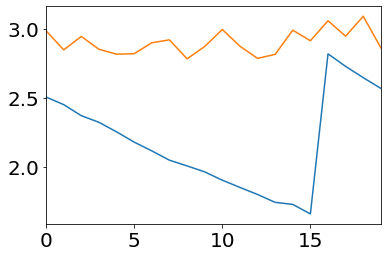

In [40]:
ax = history["train_loss"].plot()
history["valid_loss"].plot(ax=ax)

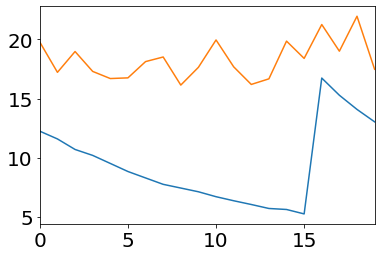

In [41]:
ax = history["TPL"].plot()
history["VPL"].plot(ax=ax)

In [42]:
l = evaluate(model, test_iterator, criterion)

print("LOSS: ",l," PPL: ", math.exp(l))


LOSS:  2.927277594804764  PPL:  18.67671563500252


In [43]:
model.load_state_dict(torch.load("checkpoint.pt", map_location=device))

<All keys matched successfully>

In [44]:
l = evaluate(model, test_iterator, criterion)

print("LOSS: ",l," PPL: ", math.exp(l))


LOSS:  2.9574341773986816  PPL:  19.24852005269147
